## Chapter 6 - Iterating the population model



### Objectives



-   Add a `System` object to add system parameters to the simulation.
-   Encapsulate previous code in a simulation function.
-   Make a better model with growth proportional to the population.
-   Higher order functions calling functions as parameters.



### System objects



`State` objects contain *state variables* that are updated in the course
of a simulation.

`System` objects contain *system parameters* that are not updated in the
course of a simulation.

For example, in the bike share model, the number of bikes at each
location is updated whenever a customer moves a bike.

System parameters in the bike share model include: number of
locations, total number of bikes, arrival rates at each location.

In the population model, the only state variable is the
population. System parameters include the annual growth rate, the
initial population, and the start and end times.



### Setup



This section only serves as a setup for the work done so far:



In [1]:
# import read_html from pandas
from pandas import read_html

# import decorate from modsim
from modsim import decorate

# getting the data
tables = read_html("data/world_population_estimates.html",
                     header=0,index_col=0,decimal='M')

# extracting table and changing column names
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison',
                  'hyde', 'tanton', 'biraben', 'mj',
                  'thomlinson', 'durand', 'clark']

# transforming the data
un = table2.un / 1e9
census = table2.census / 1e9

# plot UN census and UN DESA population estimates
def plot_estimates():
    census.plot(style=':',label='US Census')
    un.plot(style='--',label='UN DESA')
    decorate(xlabel='Year',ylabel='World population [bn]')

# computing elapsed time
t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

# computing total and annual growth
p_0 = census[t_0]
p_end = census[t_end]
total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

### Create a `System` object



To create a `System` object, we use `modsim.System`, specify the
parameters we need, and initialize them with our current values:



In [1]:
from modsim import System

system = System(t_0 = t_0,
                t_end = t_end,
                p_0 = p_0,
                annual_growth = annual_growth)
print(system)

System(t_0=1950, t_end=2016, p_0=2.557628654, annual_growth=0.07224800083333333)

The `System` variables are local to the `system` instance and they can be
changed without affecting the global values.

Print the variables using `modsim.show`:



In [1]:
from modsim import show

print(show(system))

value
t_0            1950.000000
t_end          2016.000000
p_0               2.557629
annual_growth     0.072248

### Create a simulation function



Wrap the code from before used to simulate the model in a function:



In [1]:
# load modsim.TimeSeries
from modsim import TimeSeries

# run system simulation
def run_simulation1(system):

    # initialize TimeSeries for results
    results = TimeSeries()
    results[system.t_0] = system.p_0

    # iterate assuming constant growth
    for t in range(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth

    return results

Call the simulation function:



In [1]:
results1 = run_simulation1(system)

Assuming `plot_estimates` is defined, `plot` the results:



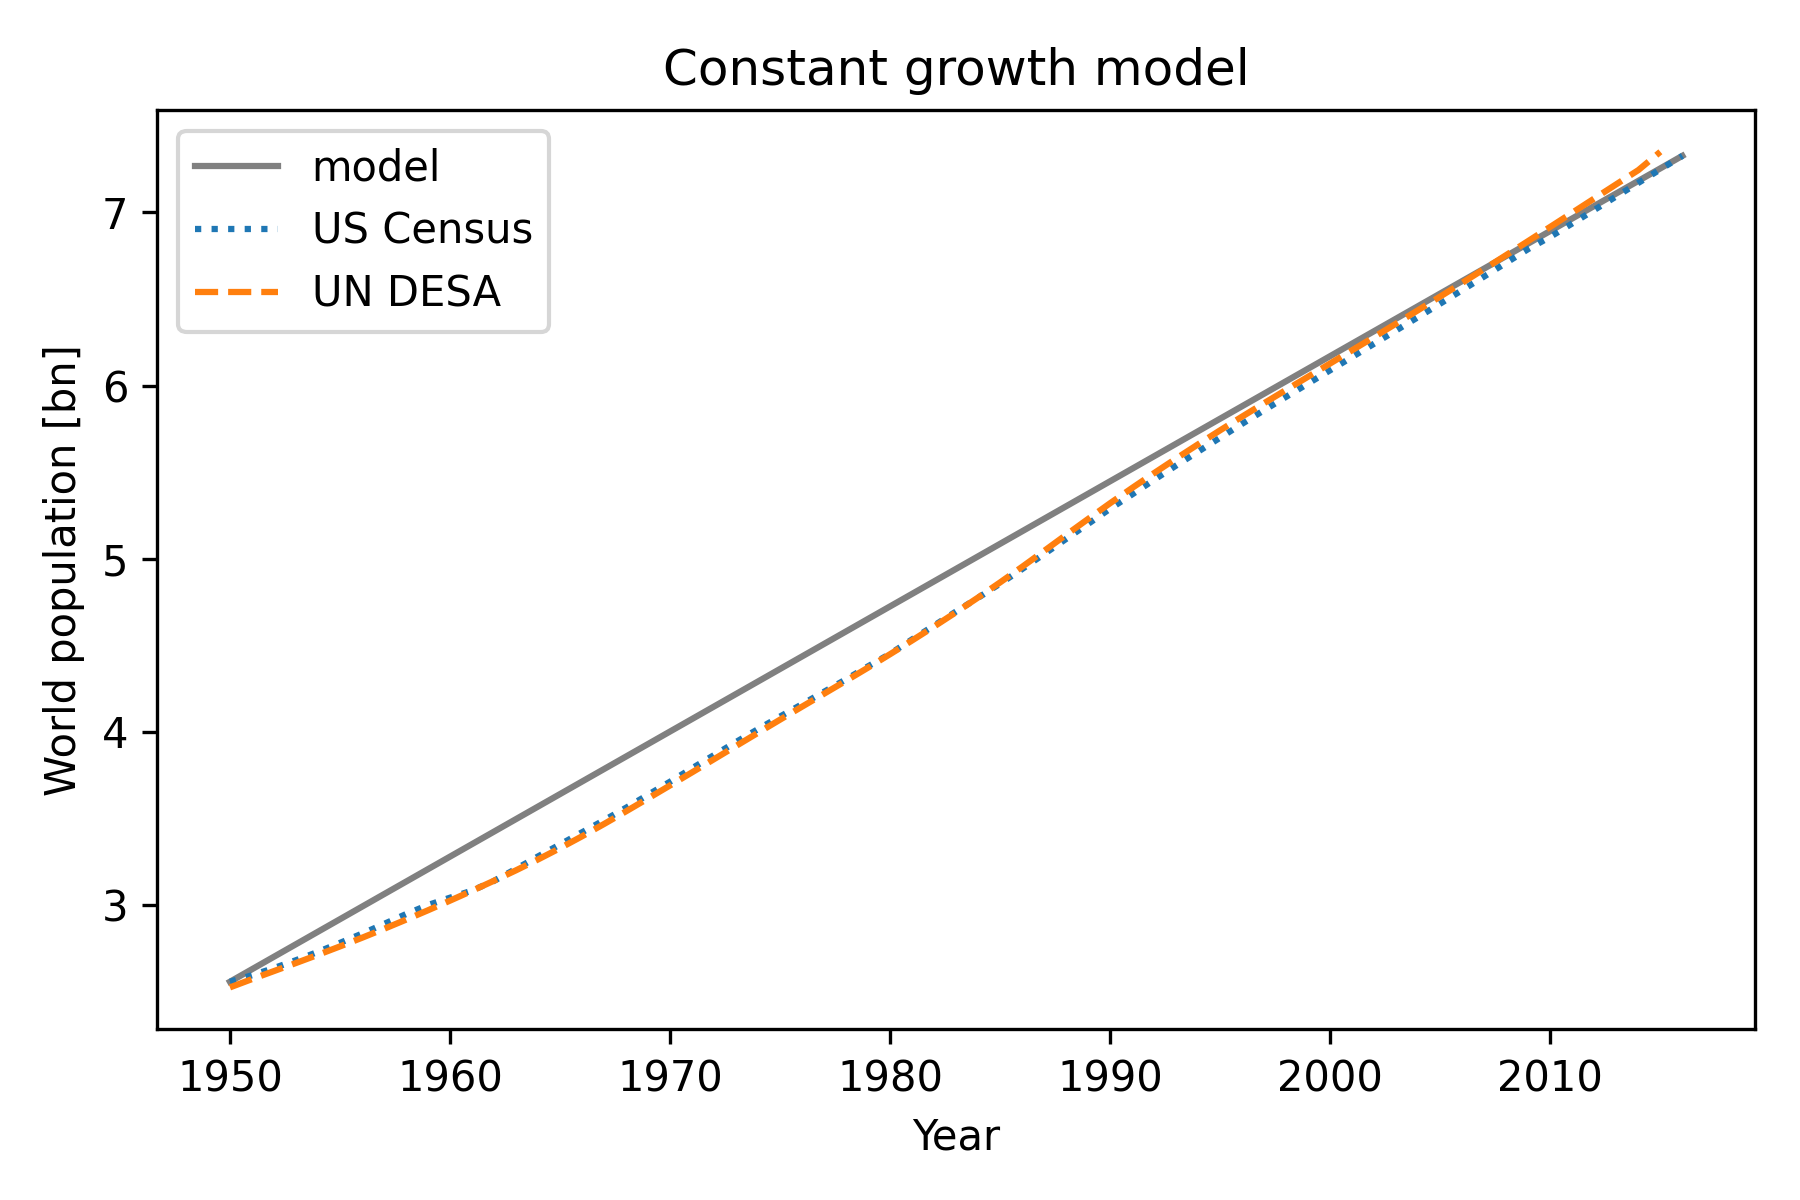

In [1]:
# import modsim.decorate for plot customization
from modsim import decorate

# import matplotlib for plot clean file/show methods
import matplotlib.pyplot as plt

plt.clf()

# plot results1, label as `model` in color `gray`
results1.plot(label='model',color='gray')
# plot estimates from historical data
plot_estimates()
# title plot
decorate(title='Constant growth model')

plt.savefig('img/results1.png')

Using functions and `System` objects may not seem like an improvement
but for bigger models, this kind of code organization makes a big
difference.



### Building a proportional growth model



The constant growth model doesn't make any sense. Realistic growth is
a function of births and deaths, and we need to model this,
introducing two new system parameters, `birth_rate` and `death_rate`.

We define a new version of the `run_simulation1` function. The constant
`annual_growth` is replace by time-dependent `births` and `deaths`:



In [1]:
# define function
def run_simulation2(system):

    # initialize system state
    results = TimeSeries()
    results[system.t_0] = system.p_0

    # iterate over years accounting for births and deaths
    for t in range(system.t_0, system.t_end):
        # births/deaths in/decrease the current population
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        # update results accordingly
        results[t+1] = results[t] + births - deaths

    return results

We fix the birth and death rate parameters so that they best fit the
real data for 2020 values ([source](https://www.indexmundi.com/world/death_rate.html)):



In [1]:
system.death_rate = 7.7 / 1000
system.birth_rate = 25 / 1000

Run the simulation and plot the results as before:



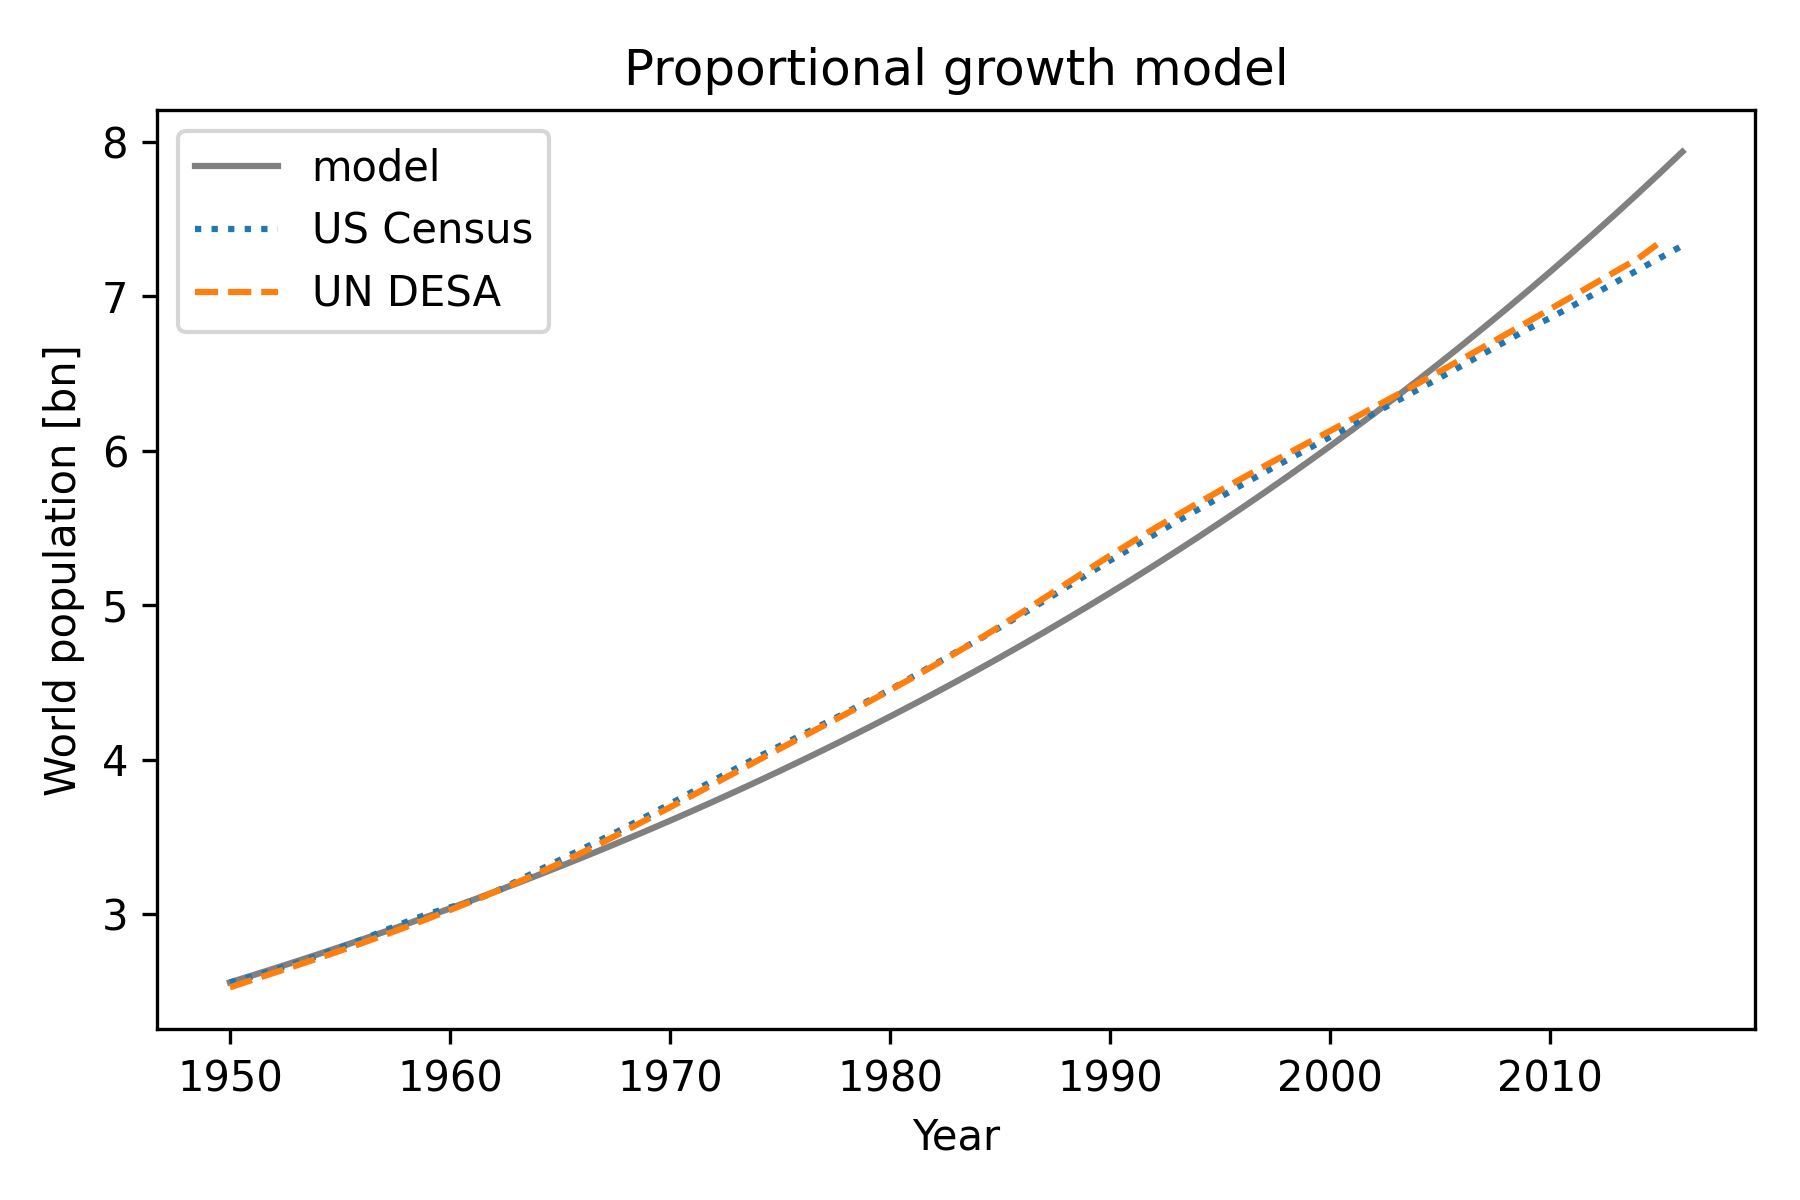

In [1]:
plt.clf()
# run_simulation2 for the system to create results2
results2 = run_simulation2(system)
# plot results2, distinguish model by gray line color
results2.plot(label='model',color='gray')
# plot estimates from historical data
plot_estimates()
# customize with title
decorate(title='Proportional growth model')

plt.savefig('img/results2.png')
plt.show()

The quality of fit of this model is not as good as the constant growth
model even though we added more realism! It only performs well from
1950 to 1960.

To find a better model, we will model a non-linear relationship
between the net population growth and the current population, and
vary the growth rate over time ([see here](https://www.indexmundi.com/g/g.aspx?c=xx&v=26)).



### Factoring out the update function



We factor out reusable code from both simulation functions and
separate things that change from things that don't change over time:



In [1]:
# define growth function
def growth_func1(pop, system):

    # compute births and deaths
    births = system.birth_rate * pop
    deaths = system.death_rate * pop      

    # return net growth value
    return births - deaths

The refactored simulation function now reads:



In [1]:
# define function
def run_simulation(system, growth_func):

    # initialize system state
    results = TimeSeries()
    results[system.t_0] = system.p_0

    # iterate over years accounting for non-constant growth
    for t in range(system.t_0, system.t_end):
        # call growth function for current population
        growth = growth_func(results[t], system)
        # update results by adding growth
        results[t+1] = results[t] + growth

    return results

Notice that this function takes a function as a parameter. When it is
called, it calls the other function:



In [1]:
results = run_simulation(system, growth_func1)

Each time through the loop, `growth_func1` is called to compute the
current year's net growth to compute next year's population.

Check if you get the same plot as before with the new simulation
function using these `results`:



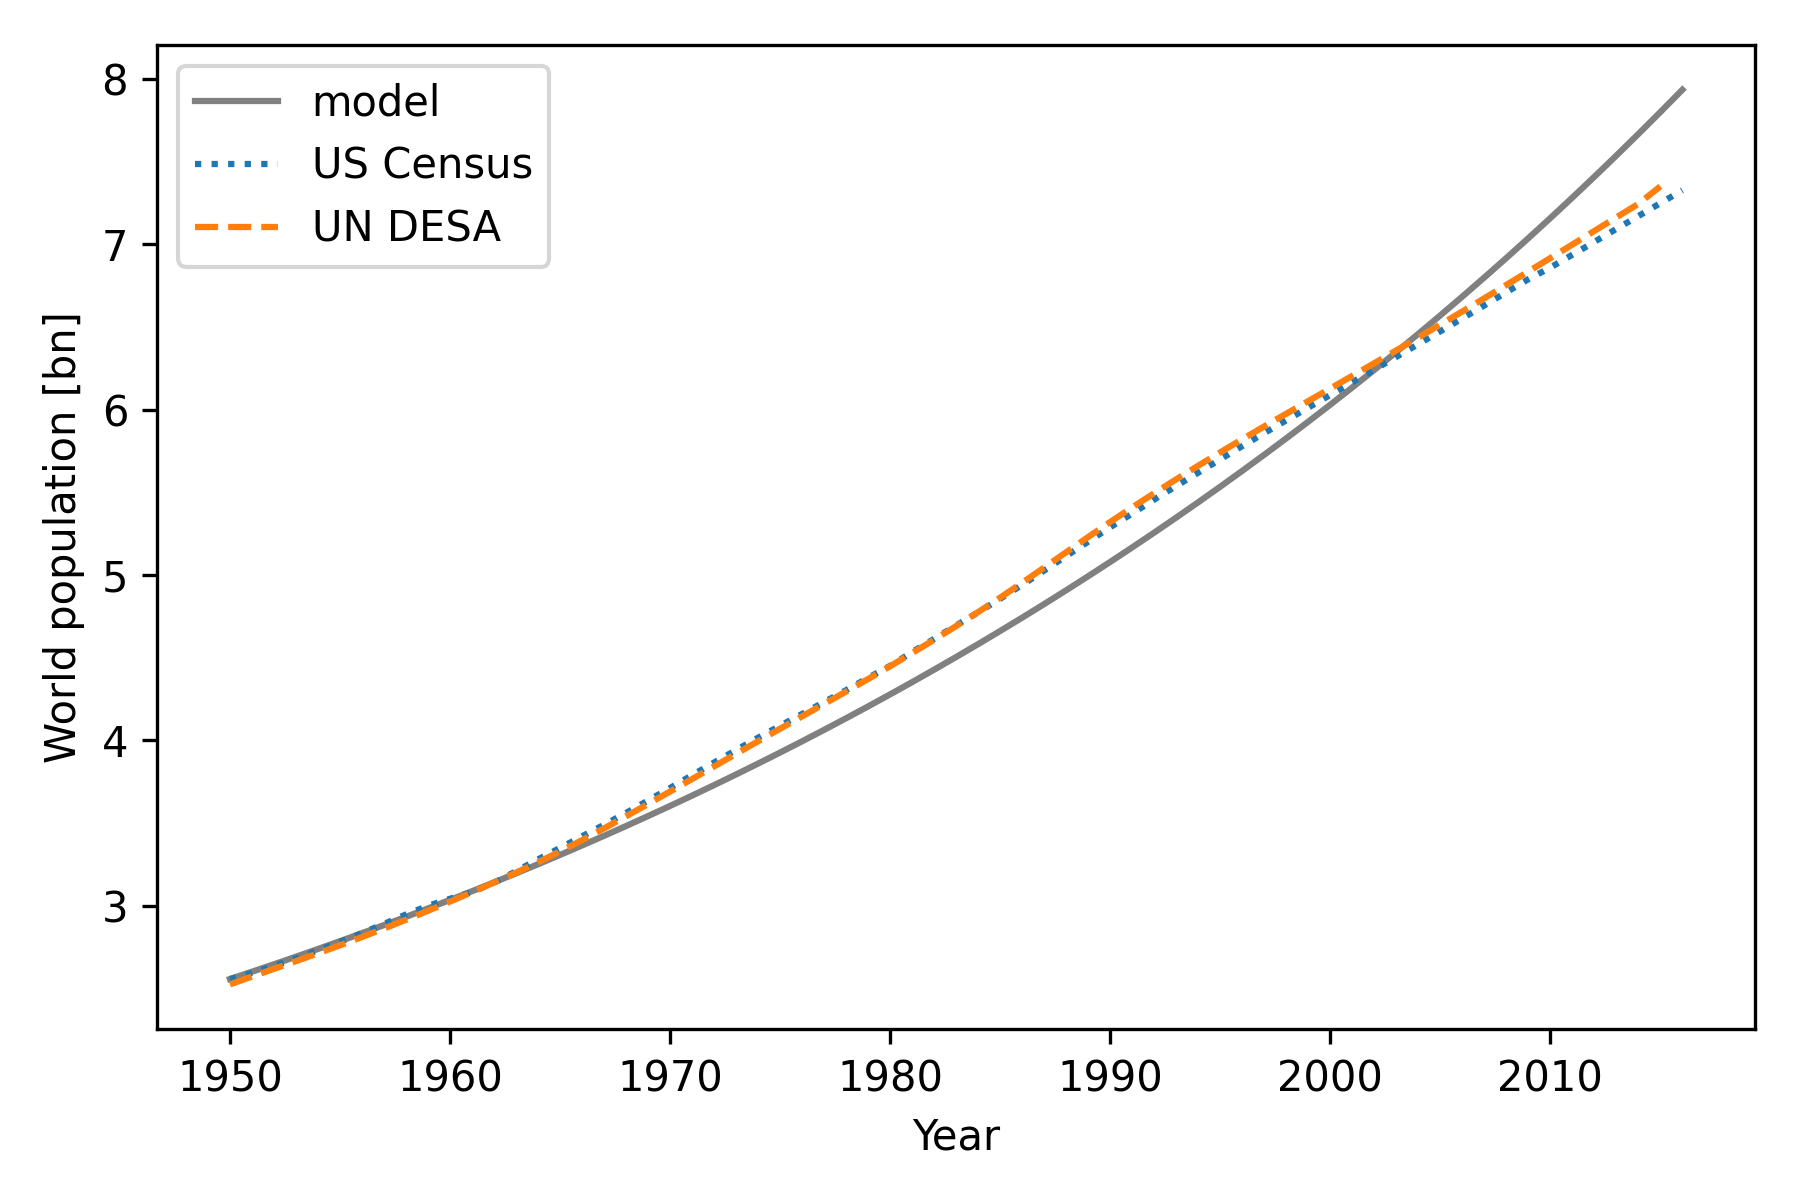

In [1]:
plt.clf()
results.plot(label='model',color='gray')
plot_estimates()
plt.savefig('img/results.png')

### Combining birth and death



In production code, you want to reduce the number of operations. We
can simplify the repeatedly called growth function by combining birth
and death rates into a single parameter `alpha`:



In [1]:
system.alpha = system.birth_rate - system.death_rate

In modeling theory, $\alpha$ is the conventional name for a proportional
growth rate.

Modify the growth function:



In [1]:
# define growth function
def growth_func2(pop, system):

    # return net growth value alpha
    return system.alpha * pop

Run it and plot the curve from before to check:



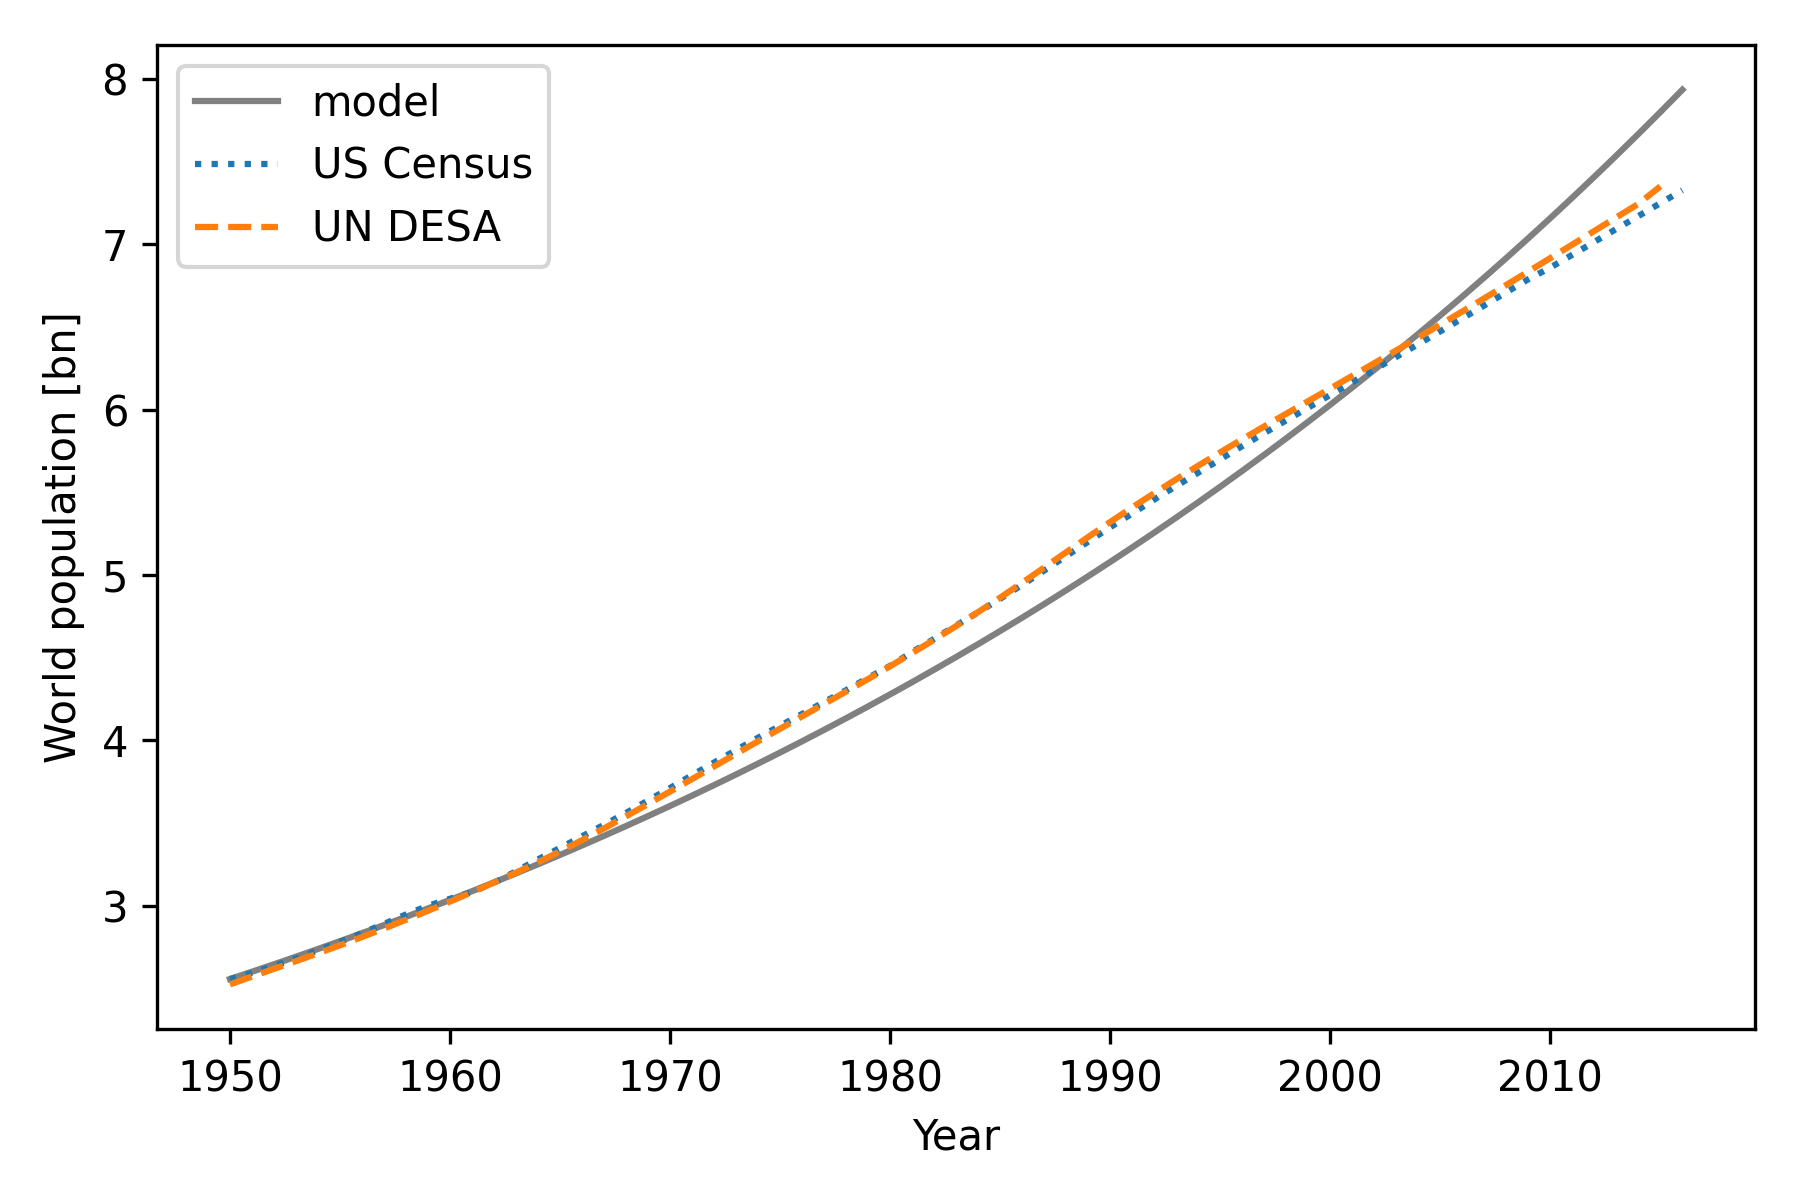

In [1]:
results = run_simulation(system,growth_func2)
plt.clf()
results.plot(label='model',color='gray')
plot_estimates()
plt.savefig('img/results3.png')